In [ ]:
! pip install jsonlines
! pip install fast_ml --quiet
! pip install transformers
! pip install nltk
! python -m nltk.downloader all
! pip install unidecode
! pip install textblob
from unidecode import unidecode
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import tensorflow as tf
import transformers
from textblob import TextBlob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    

In [ ]:
import jsonlines
# open annotated Json-L file
list_file = jsonlines.open('/content/drive/MyDrive/Dissertation/admin.jsonl')
documents=[]
for i in list_file:
  documents.append(i)

In [ ]:
documents

[{'id': 33284,
  'text': 'LR11.\n\nLR12.\n\nLR13.\n\nLR14.\n\nthe Property\n\nEasements\n\nEstate rentcharge burdening the Property\nApplication for standard form of restriction\n\nDeclaration of trust where there is more\nthan one person comprising the Tenant\n\nLR11.1\n\nNone\n\nLR11.2\n\nNone\n\nNone\n\nNone\n\nEasements granted by this\nlease for the benefit of the\nProperty\n\nEasements granted or\nreserved by this lease over the\nProperty for the benefit of\nother property\n\x0cstrict compliance with terms of this lease, the Guarantor\'s obligation remains fully effective.\nThis guarantee shail only subsist for such period and extend to such liabilities restrictions and\nother requirements as are permitted by the 1995 Act.\n\nCertificate\n16. It is certified that there is no agreement for lease (or tack) to which this lease gives effect.\nThird Parties\n\n17. No term in this lease is intended in the absence of express contrary provisions to be\nenforceable by virtue of the Contra

In [ ]:
# Extract corresponding text and store in a pandas dataframe
import pandas as pd
def index(document):
  training = pd.DataFrame(columns=['label','Text'])
  for i in range(0,len(document)):
    text = documents[i].get("text")
    entities = documents[i].get("label")
    for z in range(0,len(entities)):
      start_offset = entities[z][0]
      end_offset = entities[z][1]
      label = entities[z][2]
      text_ext = text[start_offset:end_offset] #Extract text by its position in list
      list_row = {'label': label, 'Text': text_ext}
      training = training.append(list_row,ignore_index=True)
      z+=1
    i+=1
  return training
result = index(documents)

In [ ]:
# Preprocess the dataset for word embedding
def pre_process(text):
    # convert input corpus to lower case.
    text = text.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    text = " ".join([i for i in word_tokenize(text) if i not in stopset])
    return text

# Lemmatization and spell check
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

# Word Tokenisationb & Lemmatization
def word_token(sentence):
  words = word_tokenize(sentence)
  for w in range(0,len(words)):
    words[w]=lemmatizer.lemmatize(words[w])
    w+=1
  words = ' '.join(words)
  return words

# Combination of preprocess spelling and lemetization funcitons
def lemmatization(dataset):
  processed_text = []
  for i in range(0,len(dataset)):
    text = dataset.iloc[i][1]
    text_new = pre_process(text)
    word_orig = word_token(text_new)
    processed_text.append(word_orig)
    i+=1
  dataset['processed_text'] = processed_text
  return dataset
# Apply to result
lemmatization(result)
result = result.drop('Text',axis=1)

In [ ]:
# Map Label to columns
result['label_cat'] = result['label']
result['label_cat'] = pd.factorize(result['label_cat'])[0]

In [ ]:
# Save the dataset as a parquet file
result.to_parquet('/content/drive/MyDrive/Dissertation/Data/df.parquet')

In [ ]:
# Split the dataset into train and test dataset
from sklearn.model_selection import train_test_split
# Due to imbalance in class labels, use stratified spliting on label_cat
X= result['processed_text']
y= result['label_cat']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
# concatenate X and y variables into one dataset and store as parquet files
train_df = pd.concat([train_x,train_y],axis=1)
test_df = pd.concat([test_x,test_y],axis=1)
train_df.to_parquet('/content/drive/MyDrive/Dissertation/Data/train_df.parquet')
test_df.to_parquet('/content/drive/MyDrive/Dissertation/Data/test_df.parquet')

In [ ]:
# Load data
import pandas as pd
result = pd.read_parquet('/content/drive/MyDrive/Dissertation/Data/df.parquet')

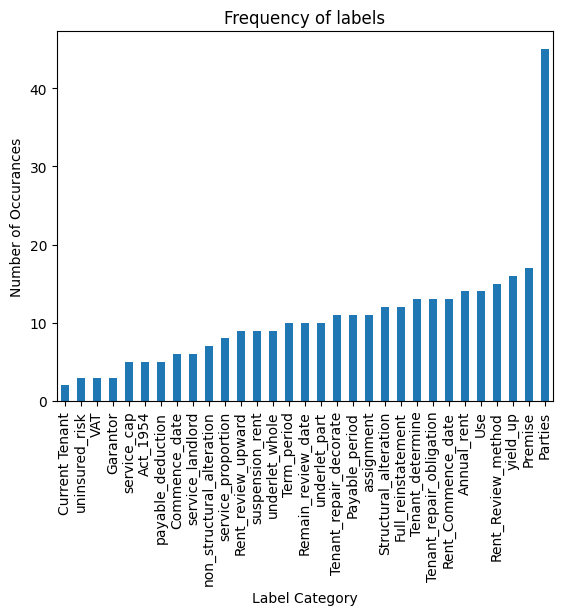

In [ ]:
# Visualise frequency of labelling
list_count = result['label'].value_counts(ascending=True).plot(kind='bar',
                                                                     title='Frequency of labels',
                                                                     xlabel= 'Label Category',
                                                                     ylabel = 'Number of Occurances')
# Save figure
fig = list_count.get_figure()
fig.savefig('/content/drive/MyDrive/Dissertation/Data/Label_distribution.png', bbox_inches="tight")